# Dự Đoán Giá Cổ Phiếu FPT - LTSF-Linear với Advanced Grid Search

## Mục tiêu:
- Dự đoán giá đóng cửa FPT cho 100 ngày tiếp theo
- Grid Search toàn diện trên:
  - **Models**: Linear, DLinear, NLinear
  - **Variants**: Univariate (1 feature) vs Multivariate (nhiều features)
  - **Normalization**: RevIN vs No RevIN
  - **Sequence Lengths**: 7, 15, 30, 60, 120, 480
  - **Regime Switching**: HMM với 3-4 regimes

## 1. Import Libraries và Setup

In [1]:
# Install dependencies if needed
!pip install hmmlearn -q

In [2]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import timedelta
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hmmlearn.hmm import GaussianHMM

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

def seed_everything(seed=42):
    """Set random seed for reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

/home/rin/.conda/envs/rin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device available: CUDA


## 2. Configuration - Hyperparameters

In [ ]:
# === CONFIGURATION ===
DATA_PATH = 'data/FPT_train.csv'
SUBMISSION_DIR = 'submissions/default'
PRED_LEN = 100  # Predict 100 days ahead
TARGET_COL = 'close'

# Grid Search Space
MODEL_TYPES = ['Linear', 'DLinear', 'NLinear']
VARIANTS = ['Univariate', 'Multivariate']
USE_REVIN_OPTIONS = [True, False]
SEQ_LENS = [7, 15, 30, 60, 120, 480]
USE_HMM_OPTIONS = [False, True]
N_REGIMES_OPTIONS = [3, 4]
REGIME_WINDOWS = [30, 60]

# Training Hyperparams
BATCH_SIZE = 32
EPOCHS = 1000
PATIENCE = 15
LEARNING_RATE = 1e-3

# Create directories
os.makedirs(SUBMISSION_DIR, exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f"Configuration:")
print(f"  - Prediction Length: {PRED_LEN} days")
print(f"  - Model Types: {MODEL_TYPES}")
print(f"  - Variants: {VARIANTS}")
print(f"  - RevIN Options: {USE_REVIN_OPTIONS}")
print(f"  - Sequence Lengths: {SEQ_LENS}")
print(f"  - HMM Regimes: {N_REGIMES_OPTIONS}")

# Calculate total experiments (Filter NLinear + RevIN)

# 1. Count valid (Model, RevIN) pairs
# Linear(T/F) + DLinear(T/F) + NLinear(F) = 5 pairs
valid_model_revin_pairs = 0
for m in MODEL_TYPES:
    for r in USE_REVIN_OPTIONS:
        if m == 'NLinear' and r: # Skip NLinear + RevIN
            continue
        valid_model_revin_pairs += 1

# 2. Count No-HMM experiments
# Variants * Seq_Lens * Valid_Pairs
total_no_hmm = len(VARIANTS) * len(SEQ_LENS) * valid_model_revin_pairs

# 3. Count HMM experiments
# HMM only runs on seq_len < 120 (4 seq_lens: 7, 15, 30, 60)
short_seq_lens_count = len([s for s in SEQ_LENS if s < 120])
# Variants * Short_Seq_Lens * Valid_Pairs * HMM_Configs
hmm_configs_count = len(N_REGIMES_OPTIONS) * len(REGIME_WINDOWS)
total_hmm = len(VARIANTS) * short_seq_lens_count * valid_model_revin_pairs * hmm_configs_count

total_experiments = total_no_hmm + total_hmm

print(f"\nCalculation Logic:")
print(f"  - Valid Model+RevIN pairs: {valid_model_revin_pairs} (Removed NLinear+RevIN)")
print(f"  - No HMM Experiments: {len(VARIANTS)} * {len(SEQ_LENS)} * {valid_model_revin_pairs} = {total_no_hmm}")
print(f"  - HMM Experiments: {len(VARIANTS)} * {short_seq_lens_count} * {valid_model_revin_pairs} * {hmm_configs_count} = {total_hmm}")
print(f"\nEstimated total experiments: {total_experiments}")

Configuration:
  - Prediction Length: 100 days
  - Model Types: ['Linear', 'DLinear', 'NLinear']
  - Variants: ['Univariate', 'Multivariate']
  - RevIN Options: [True, False]
  - Sequence Lengths: [7, 15, 30, 60, 120, 480]
  - HMM Regimes: [3, 4]

Calculation Logic:
  - Valid Model+RevIN pairs: 5 (Removed NLinear+RevIN)
  - No HMM Experiments: 2 * 6 * 5 = 60
  - HMM Experiments: 2 * 4 * 5 * 4 = 160

Estimated total experiments: 220


## 3. Load Data và EDA

In [4]:
# Load data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min().date()} to {df['time'].max().date()}")
print(f"\nFirst few rows:")
display(df.head())

print(f"\nData types:")
print(df.dtypes)

print(f"\nBasic statistics:")
display(df.describe())

Dataset shape: (1149, 7)
Date range: 2020-08-03 to 2025-03-10

First few rows:


,time,open,high,low,close,volume,symbol
0,2020-08-03,19.07,19.63,19.03,19.63,1392200,FPT
1,2020-08-04,19.89,20.01,19.76,19.91,1051310,FPT
2,2020-08-05,19.89,20.16,19.78,20.10,1328520,FPT
3,2020-08-06,20.10,20.21,19.97,20.01,1153660,FPT
4,2020-08-07,20.01,20.44,20.01,20.14,1283690,FPT



Data types:
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object

Basic statistics:


,time,open,high,low,close,volume
count,1149,1149.000000,1149.000000,1149.000000,1149.000000,1.149000e+03
mean,2022-11-18 03:30:32.898172416,61.965666,62.625483,61.349721,61.999182,2.444857e+06
min,2020-08-03 00:00:00,19.070000,19.630000,19.030000,19.630000,2.219660e+05
25%,2021-09-24 00:00:00,46.690000,47.180000,46.110000,46.640000,1.244928e+06
50%,2022-11-16 00:00:00,51.340000,51.860000,50.890000,51.290000,1.984701e+06
75%,2024-01-09 00:00:00,71.730000,72.470000,71.060000,71.580000,3.062690e+06
max,2025-03-10 00:00:00,132.870000,134.500000,132.260000,133.040000,1.372370e+07
std,NaN,29.457209,29.700736,29.221866,29.462158,1.821708e+06


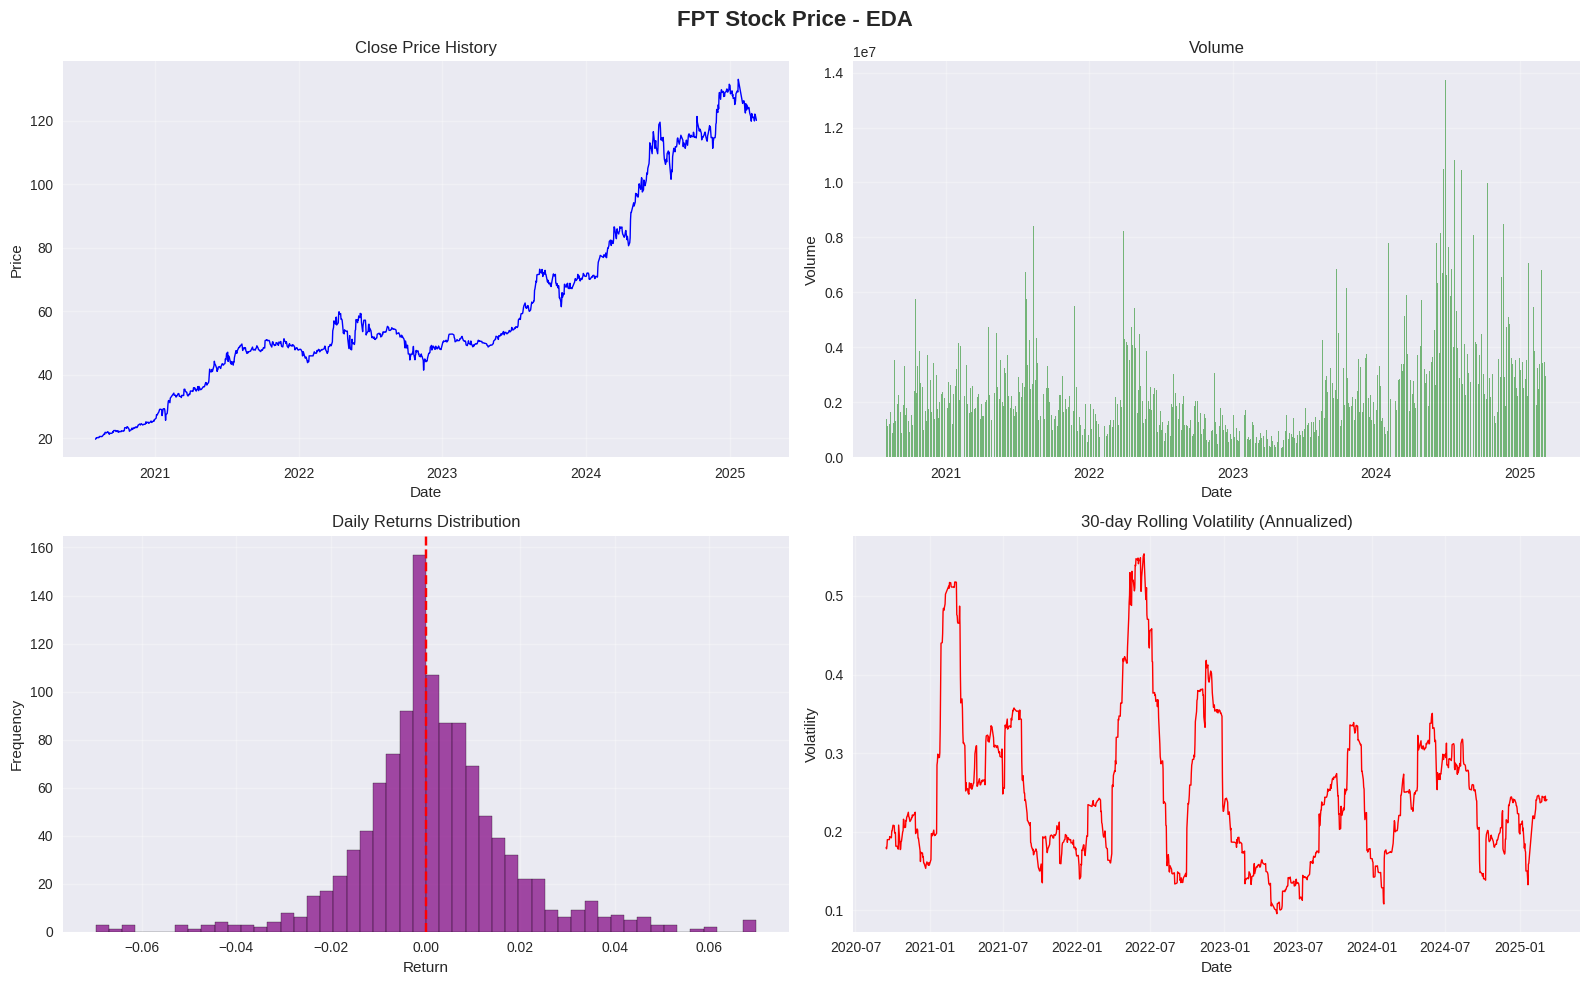

In [5]:
# Visualize price history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('FPT Stock Price - EDA', fontsize=16, fontweight='bold')

# Price history
axes[0, 0].plot(df['time'], df['close'], color='blue', linewidth=1)
axes[0, 0].set_title('Close Price History')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].grid(True, alpha=0.3)

# Volume
axes[0, 1].bar(df['time'], df['volume'], color='green', alpha=0.5, width=1)
axes[0, 1].set_title('Volume')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Daily returns distribution
returns = df['close'].pct_change().dropna()
axes[1, 0].hist(returns, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Daily Returns Distribution')
axes[1, 0].set_xlabel('Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

# Rolling volatility
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
axes[1, 1].plot(df['time'].iloc[1:], rolling_vol, color='red', linewidth=1)
axes[1, 1].set_title('30-day Rolling Volatility (Annualized)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Feature Engineering & Data Preprocessing

In [6]:
# === FEATURE ENGINEERING ===

# Log Transform (stabilize variance)
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[f'{col}_log'] = np.log1p(df[col])

# Spread Features
df['HL_Spread'] = df['high_log'] - df['low_log']  # Intraday range
df['OC_Spread'] = df['close_log'] - df['open_log']  # Open-Close spread

# Returns & Volatility for HMM Regime Detection
df['returns'] = df['close'].pct_change().fillna(0)
df['volatility'] = df['returns'].rolling(window=10).std().fillna(0)
df['trend'] = df['close'].rolling(window=10).mean().pct_change().fillna(0)

print("Features created:")
print(f"  - Log transforms: open_log, high_log, low_log, close_log, volume_log")
print(f"  - Spread features: HL_Spread, OC_Spread")
print(f"  - HMM features: returns, volatility, trend")

print(f"\nDataset shape after feature engineering: {df.shape}")
display(df.tail())

Features created:
  - Log transforms: open_log, high_log, low_log, close_log, volume_log
  - Spread features: HL_Spread, OC_Spread
  - HMM features: returns, volatility, trend

Dataset shape after feature engineering: (1149, 17)


,time,open,high,low,close,volume,symbol,open_log,high_log,low_log,close_log,volume_log,HL_Spread,OC_Spread,returns,volatility,trend
1144,2025-03-04,120.28,121.23,120.11,120.71,3480042,FPT,4.798102,4.805905,4.796699,4.801641,15.062555,0.009205,0.003539,-0.003550,0.009010,-0.002752
1145,2025-03-05,120.71,120.80,119.93,119.93,2862185,FPT,4.801641,4.802380,4.795212,4.795212,14.867096,0.007168,-0.006429,-0.006462,0.008993,-0.003474
1146,2025-03-06,120.28,123.73,120.28,122.09,6428376,FPT,4.798102,4.826151,4.798102,4.812916,15.676233,0.028049,0.014814,0.018011,0.011120,-0.000997
1147,2025-03-07,122.18,123.04,121.66,121.92,2966941,FPT,4.813647,4.820604,4.809416,4.811534,14.903042,0.011188,-0.002113,-0.001392,0.010915,-0.000421
1148,2025-03-10,122.00,122.00,120.02,120.11,5343134,FPT,4.812184,4.812184,4.795956,4.796699,15.491323,0.016229,-0.015485,-0.014846,0.011434,-0.000850


In [7]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("✓ No missing values!")

✓ No missing values!


## 5. Dataset và Sliding Window

In [8]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series forecasting"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def create_sliding_window(data, seq_len, pred_len, target_col_idx, feature_cols_idx):
    """
    Create sliding window sequences for time series forecasting.
    """
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i : i + seq_len, feature_cols_idx])
        y.append(data[i + seq_len : i + seq_len + pred_len, target_col_idx])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print("Dataset classes defined!")

Dataset classes defined!


## 6. Regime Detector (Hidden Markov Model)

In [9]:
class RegimeDetector:
    """
    Detect market regimes using Gaussian HMM.
    Uses returns, volatility, and trend as features.
    """
    def __init__(self, n_components=3, window=30):
        self.n_components = n_components
        self.window = window
        self.model = GaussianHMM(
            n_components=n_components, 
            covariance_type="full", 
            n_iter=100, 
            random_state=42
        )
        
    def fit_predict(self, df):
        """Fit HMM and predict regimes"""
        features = df[['returns', 'volatility', 'trend']].iloc[self.window:].values
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        self.model.fit(features_scaled)
        states = self.model.predict(features_scaled)
        
        full_states = np.concatenate([np.zeros(self.window) - 1, states])
        return full_states

print("RegimeDetector class defined!")

RegimeDetector class defined!


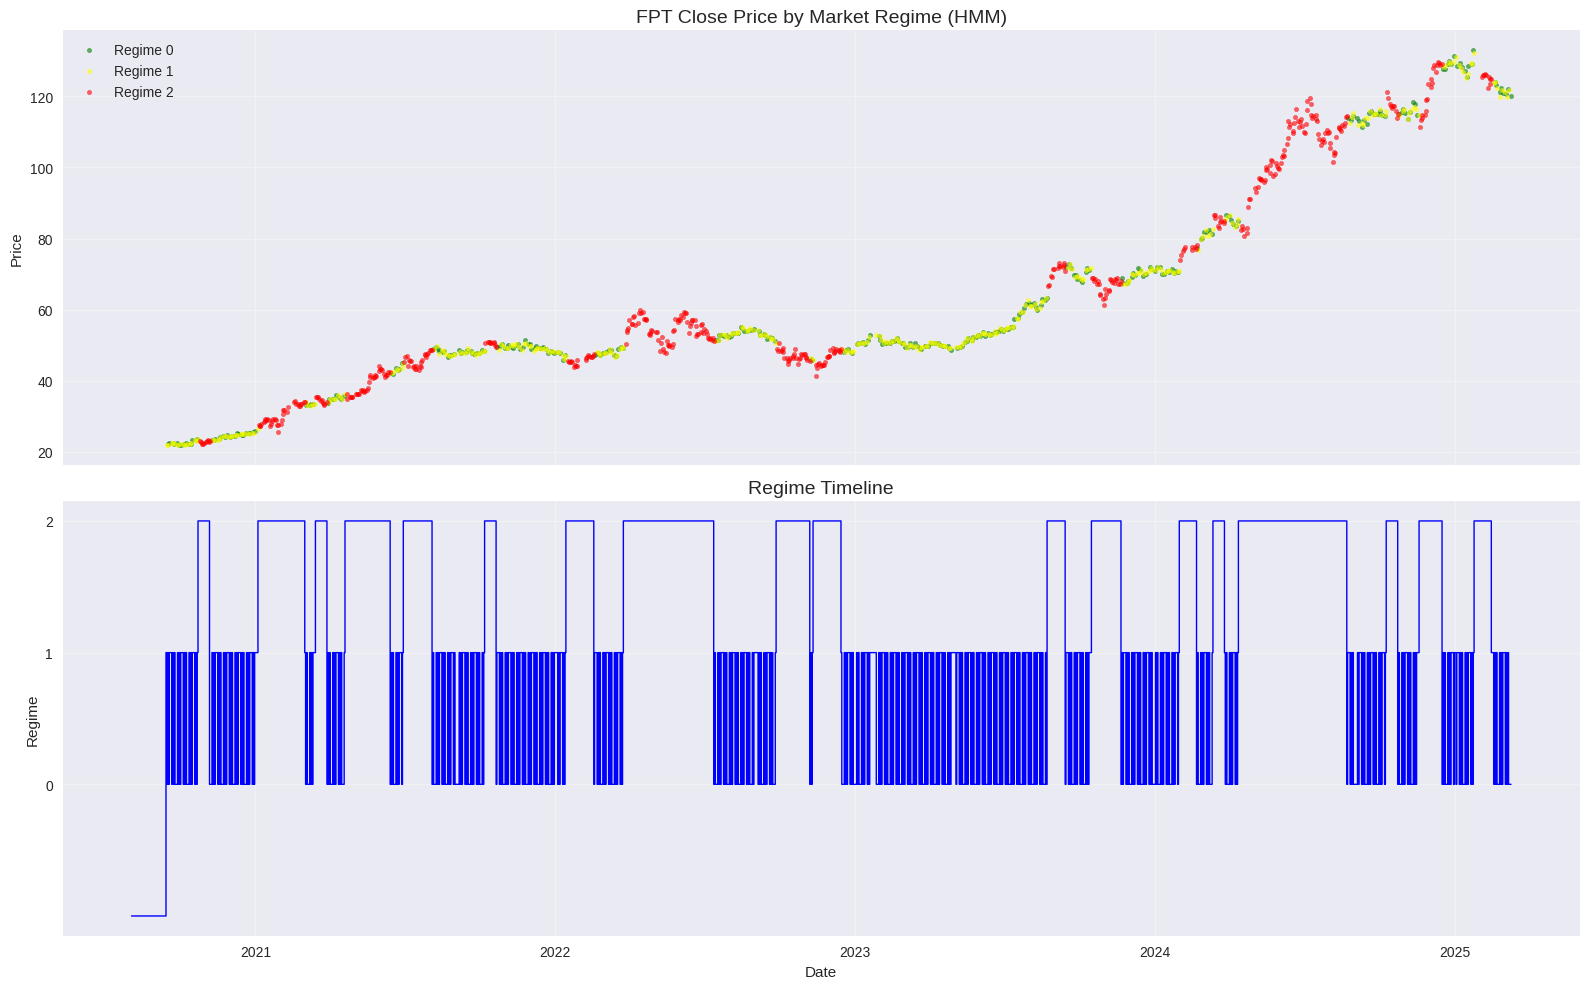


Regime Distribution:
  Regime 0: 326 days (28.4%)
  Regime 1: 329 days (28.6%)
  Regime 2: 464 days (40.4%)


In [10]:
# Visualize HMM Regimes
detector = RegimeDetector(n_components=3, window=30)
regimes = detector.fit_predict(df)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

colors = ['green', 'yellow', 'red']
for regime in range(3):
    mask = regimes == regime
    axes[0].scatter(df['time'][mask], df['close'][mask], 
                   c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=10)

axes[0].set_title('FPT Close Price by Market Regime (HMM)', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['time'], regimes, drawstyle='steps', color='blue', linewidth=1)
axes[1].set_title('Regime Timeline', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Regime')
axes[1].set_yticks([0, 1, 2])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegime Distribution:")
for r in range(3):
    count = (regimes == r).sum()
    pct = count / len(regimes) * 100
    print(f"  Regime {r}: {count} days ({pct:.1f}%)")

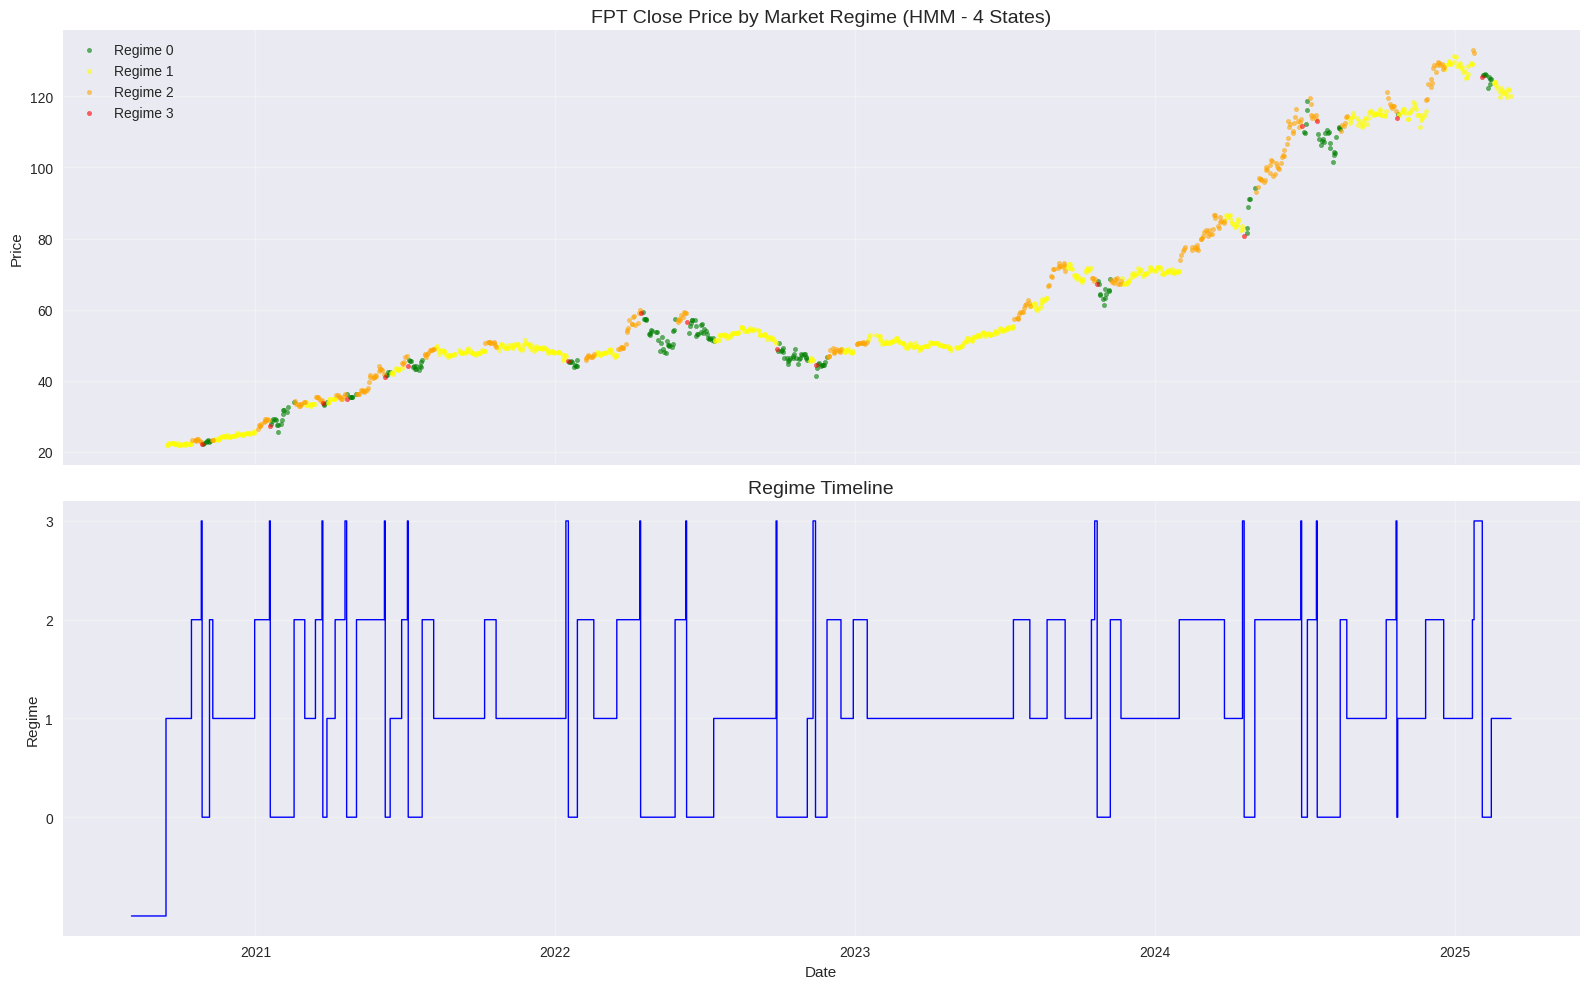


Regime Distribution:
  Regime 0: 199 days (17.3%)
  Regime 1: 596 days (51.9%)
  Regime 2: 307 days (26.7%)
  Regime 3: 17 days (1.5%)


In [11]:
# Visualize HMM Regimes (4 States)
detector = RegimeDetector(n_components=4, window=30)
regimes = detector.fit_predict(df)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# 4 màu cho 4 regimes
colors = ['green', 'yellow', 'orange', 'red'] 

for regime in range(4):
    mask = regimes == regime
    # Dùng try-except đề phòng trường hợp HMM ra ít hơn 4 nhóm (hiếm gặp)
    if mask.sum() > 0:
        axes[0].scatter(df['time'][mask], df['close'][mask], 
                       c=colors[regime], label=f'Regime {regime}', alpha=0.6, s=10)

axes[0].set_title('FPT Close Price by Market Regime (HMM - 4 States)', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['time'], regimes, drawstyle='steps', color='blue', linewidth=1)
axes[1].set_title('Regime Timeline', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Regime')

axes[1].set_yticks([0, 1, 2, 3]) 
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegime Distribution:")
for r in range(4):
    count = (regimes == r).sum()
    pct = count / len(regimes) * 100
    print(f"  Regime {r}: {count} days ({pct:.1f}%)")

## 7. RevIN (Reversible Instance Normalization)

In [12]:
class RevIN(nn.Module):
    """
    Reversible Instance Normalization.
    Handles distribution shift in time series forecasting.
    """
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        return x

print("RevIN class defined!")

RevIN class defined!


## 8. LTSF-Linear Models (All Variants)

In [13]:
# =====================================================
# UNIVARIATE MODELS (Chỉ dùng close_log)
# =====================================================

class Uni_Linear_RevIN(nn.Module):
    """Univariate Linear with RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.revin = RevIN(num_features)
        self.linear = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        x_in = x[:, :, 0]
        out = self.linear(x_in)
        out = out * target_stdev + target_mean
        return out


class Uni_Linear_NoRevIN(nn.Module):
    """Univariate Linear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        x_in = x[:, :, 0]
        return self.linear(x_in)


class Uni_DLinear_RevIN(nn.Module):
    """Univariate DLinear with RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.revin = RevIN(num_features)
        kernel_size = min(25, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        x_in = x[:, :, 0].unsqueeze(1)  # [B, 1, S]
        trend = self.moving_avg(x_in).squeeze(1)
        if trend.shape[1] != self.seq_len:
            trend = trend[:, :self.seq_len]
        seasonal = x[:, :, 0] - trend
        
        out = self.linear_trend(trend) + self.linear_seasonal(seasonal)
        out = out * target_stdev + target_mean
        return out


class Uni_DLinear_NoRevIN(nn.Module):
    """Univariate DLinear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        kernel_size = min(25, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        x_in = x[:, :, 0].unsqueeze(1)
        trend = self.moving_avg(x_in).squeeze(1)
        if trend.shape[1] != self.seq_len:
            trend = trend[:, :self.seq_len]
        seasonal = x[:, :, 0] - trend
        return self.linear_trend(trend) + self.linear_seasonal(seasonal)


class Uni_NLinear_NoRevIN(nn.Module):
    """Univariate NLinear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        x_in = x[:, :, 0]
        last_value = x_in[:, -1:]
        x_normalized = x_in - last_value
        pred_normalized = self.linear(x_normalized)
        return pred_normalized + last_value


print("Univariate models defined: Linear, DLinear (with/without RevIN) and NLinear")

Univariate models defined: Linear, DLinear (with/without RevIN) and NLinear


In [14]:
# =====================================================
# MULTIVARIATE MODELS (Dùng nhiều features)
# =====================================================

class Multi_Linear_RevIN(nn.Module):
    """Multivariate Linear with RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.revin = RevIN(num_features)
        self.linear = nn.Linear(seq_len * num_features, pred_len)
        
    def forward(self, x):
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        x_flat = x.reshape(x.shape[0], -1)
        out = self.linear(x_flat)
        out = out * target_stdev + target_mean
        return out


class Multi_Linear_NoRevIN(nn.Module):
    """Multivariate Linear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.linear = nn.Linear(seq_len * num_features, pred_len)
        
    def forward(self, x):
        x_flat = x.reshape(x.shape[0], -1)
        return self.linear(x_flat)


class Multi_DLinear_RevIN(nn.Module):
    """Multivariate DLinear with RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.revin = RevIN(num_features)
        
        kernel_size = min(25, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.linear_trend = nn.Linear(seq_len * num_features, pred_len)
        self.linear_seasonal = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        x = self.revin(x, 'norm')
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        # [B, S, F] -> [B, F, S] for AvgPool
        trend = self.moving_avg(x.permute(0, 2, 1)).permute(0, 2, 1)
        if trend.shape[1] != self.seq_len:
            trend = trend[:, :self.seq_len, :]
        seasonal = x - trend
        
        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)
        
        out = self.linear_trend(trend_flat) + self.linear_seasonal(seasonal_flat)
        out = out * target_stdev + target_mean
        return out


class Multi_DLinear_NoRevIN(nn.Module):
    """Multivariate DLinear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        
        kernel_size = min(25, seq_len)
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.linear_trend = nn.Linear(seq_len * num_features, pred_len)
        self.linear_seasonal = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        trend = self.moving_avg(x.permute(0, 2, 1)).permute(0, 2, 1)
        if trend.shape[1] != self.seq_len:
            trend = trend[:, :self.seq_len, :]
        seasonal = x - trend
        
        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)
        
        return self.linear_trend(trend_flat) + self.linear_seasonal(seasonal_flat)


class Multi_NLinear_NoRevIN(nn.Module):
    """Multivariate NLinear without RevIN"""
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.linear = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        last_values = x[:, -1:, :]
        x_normalized = x - last_values
        x_flat = x_normalized.reshape(x.shape[0], -1)
        
        pred_normalized = self.linear(x_flat)
        return pred_normalized + last_values[:, 0, 0:1]


print("Multivariate models defined: Linear, DLinear (with/without RevIN) and NLinear")

Multivariate models defined: Linear, DLinear (with/without RevIN) and NLinear


In [15]:
# =====================================================
# MODEL FACTORY
# =====================================================

MODEL_REGISTRY = {
    # Univariate with RevIN
    ('Univariate', 'Linear', True): Uni_Linear_RevIN,
    ('Univariate', 'DLinear', True): Uni_DLinear_RevIN,
    # Univariate without RevIN
    ('Univariate', 'Linear', False): Uni_Linear_NoRevIN,
    ('Univariate', 'DLinear', False): Uni_DLinear_NoRevIN,
    ('Univariate', 'NLinear', False): Uni_NLinear_NoRevIN,
    # Multivariate with RevIN
    ('Multivariate', 'Linear', True): Multi_Linear_RevIN,
    ('Multivariate', 'DLinear', True): Multi_DLinear_RevIN,
    # Multivariate without RevIN
    ('Multivariate', 'Linear', False): Multi_Linear_NoRevIN,
    ('Multivariate', 'DLinear', False): Multi_DLinear_NoRevIN,
    ('Multivariate', 'NLinear', False): Multi_NLinear_NoRevIN,
}

def create_model(variant, model_type, use_revin, seq_len, pred_len, num_features):
    """Factory function to create model"""
    key = (variant, model_type, use_revin)
    if key not in MODEL_REGISTRY:
        raise ValueError(f"Unknown model configuration: {key}")
    return MODEL_REGISTRY[key](seq_len, pred_len, num_features)

print(f"\nTotal model configurations: {len(MODEL_REGISTRY)}")
for key in MODEL_REGISTRY:
    print(f"  - {key[0]}_{key[1]}_{'RevIN' if key[2] else 'NoRevIN'}")


Total model configurations: 10
  - Univariate_Linear_RevIN
  - Univariate_DLinear_RevIN
  - Univariate_Linear_NoRevIN
  - Univariate_DLinear_NoRevIN
  - Univariate_NLinear_NoRevIN
  - Multivariate_Linear_RevIN
  - Multivariate_DLinear_RevIN
  - Multivariate_Linear_NoRevIN
  - Multivariate_DLinear_NoRevIN
  - Multivariate_NLinear_NoRevIN


## 9. Trainer Class

In [16]:
class Trainer:
    """Training manager with early stopping and learning rate scheduling."""
    def __init__(self, model, criterion, optimizer, scheduler, patience=10):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.patience = patience
        self.best_loss = float('inf')
        self.best_state = None
        self.counter = 0
        
    def fit(self, train_loader, val_loader, epochs, verbose=False):
        """Train the model with early stopping"""
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            
            val_loss = self.evaluate(val_loader)
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_state = deepcopy(self.model.state_dict())
                self.counter = 0
            else:
                self.counter += 1
                
            if self.counter >= self.patience:
                break
                
        if self.best_state:
            self.model.load_state_dict(self.best_state)
            
    def evaluate(self, loader):
        """Evaluate model on a dataset"""
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                total_loss += loss.item()
        return total_loss / len(loader)

print("Trainer class defined!")

Trainer class defined!


## 10. Grid Search Pipeline

In [17]:
def inverse_transform(log_data):
    """Convert log-transformed data back to original scale"""
    return np.expm1(log_data)


def train_model_func(variant, model_type, use_revin, seq_len, num_features, X_train, y_train, epochs=EPOCHS):
    """Helper function to train a single model"""
    train_loader = DataLoader(
        TimeSeriesDataset(X_train, y_train), 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    
    model = create_model(variant, model_type, use_revin, seq_len, PRED_LEN, num_features).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    trainer = Trainer(model, criterion, optimizer, scheduler, patience=PATIENCE)
    trainer.fit(train_loader, train_loader, epochs)
    
    return model


def evaluate_model_func(model, X, y):
    """Evaluate model and compute MSE on original price scale"""
    model.eval()
    loader = DataLoader(TimeSeriesDataset(X, y), batch_size=BATCH_SIZE, shuffle=False)
    
    preds_log, trues_log = [], []
    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            out = model(X_b)
            preds_log.append(out.cpu().numpy())
            trues_log.append(y_b.numpy())
    
    preds_log = np.concatenate(preds_log)
    trues_log = np.concatenate(trues_log)
    
    preds_price = inverse_transform(preds_log)
    trues_price = inverse_transform(trues_log)
    
    return mean_squared_error(trues_price.flatten(), preds_price.flatten())


def save_submission(predictions, filename):
    """Save predictions to CSV file"""
    sub_df = pd.DataFrame({
        'id': range(1, PRED_LEN + 1), 
        'close': predictions
    })
    filepath = os.path.join(SUBMISSION_DIR, filename)
    sub_df.to_csv(filepath, index=False)
    return filepath


def save_plot(history_prices, predictions, filename, title):
    """Save forecast plot"""
    # fig, ax = plt.subplots(figsize=(12, 6))
    
    # history_len = 150
    # hist_prices = history_prices.iloc[-history_len:]
    # last_date = df['time'].iloc[-1]
    # future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=PRED_LEN, freq='B')
    
    # ax.plot(range(history_len), hist_prices.values, label='History', color='black', alpha=0.7)
    # ax.plot(range(history_len, history_len + PRED_LEN), predictions, label='Forecast', color='red', linewidth=2)
    # ax.axvline(x=history_len, color='gray', linestyle='--', alpha=0.5)
    
    # ax.set_title(title, fontsize=12)
    # ax.legend()
    # ax.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.savefig(os.path.join(SUBMISSION_DIR, filename.replace('.csv', '.png')), dpi=100)
    # plt.close()
    pass

print("Training utilities defined!")

Training utilities defined!


In [18]:
def run_grid_search():
    """
    Main Grid Search Pipeline.
    Iterates over all model configurations.
    """
    results = []
    
    # Feature columns
    feature_cols = ['close_log', 'volume_log', 'HL_Spread', 'OC_Spread']
    target_col_idx = df.columns.get_loc('close_log')
    feature_cols_idx = [df.columns.get_loc(c) for c in feature_cols]
    data_values = df.values
    
    # Calculate total combinations
    total = 0
    for variant in VARIANTS:
        for model_type in MODEL_TYPES:
            for use_revin in USE_REVIN_OPTIONS:
                # Bỏ qua trường hợp thừa
                if model_type == 'NLinear' and use_revin:
                    continue
                
                for seq_len in SEQ_LENS:
                    for use_hmm in USE_HMM_OPTIONS:
                        # Logic bỏ qua HMM cho seq dài
                        if seq_len >= 120 and use_hmm:
                            continue
                        
                        # Cộng số lượng experiment
                        if use_hmm:
                            total += len(N_REGIMES_OPTIONS) * len(REGIME_WINDOWS)
                        else:
                            total += 1
                            
    pbar = tqdm(total=total, desc="Grid Search")
    
    for variant in VARIANTS:
        for model_type in MODEL_TYPES:
            for use_revin in USE_REVIN_OPTIONS:
                
                if model_type == 'NLinear' and use_revin:
                    continue

                for seq_len in SEQ_LENS:
                    for use_hmm in USE_HMM_OPTIONS:
                        
                        # Skip HMM for long sequences
                        if seq_len >= 120 and use_hmm:
                            continue
                        
                        hmm_configs = [(None, None)]
                        if use_hmm:
                            hmm_configs = [(n, w) for n in N_REGIMES_OPTIONS for w in REGIME_WINDOWS]
                        
                        for n_regimes, regime_window in hmm_configs:
                            try:
                                seed_everything(42)
                                
                                # === Data Preparation ===
                                regimes = None
                                if use_hmm:
                                    detector = RegimeDetector(n_components=n_regimes, window=regime_window)
                                    regimes = detector.fit_predict(df)
                                
                                # Train/Val split (80/20)
                                train_size = int(len(data_values) * 0.8)
                                train_data = data_values[:train_size]
                                val_data = data_values[train_size - seq_len:]
                                
                                X_train, y_train = create_sliding_window(train_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                                X_val, y_val = create_sliding_window(val_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                                
                                num_features = len(feature_cols_idx)
                                
                                # === Train Global Model (Baseline) ===
                                global_model = train_model_func(variant, model_type, use_revin, seq_len, num_features, X_train, y_train)
                                
                                # === Evaluation ===
                                if not use_hmm:
                                    val_mse = evaluate_model_func(global_model, X_val, y_val)
                                else:
                                    val_mse = evaluate_with_hmm(
                                        global_model, variant, model_type, use_revin,
                                        seq_len, num_features,
                                        X_train, y_train, X_val, y_val,
                                        regimes, train_size
                                    )
                                
                                # === Production Forecast ===
                                # 1. Train Global Model trên full data (hoặc 95% data)
                                prod_train_size = int(len(data_values) * 0.95)
                                prod_train_data = data_values[:prod_train_size]
                                X_prod, y_prod = create_sliding_window(prod_train_data, seq_len, PRED_LEN, target_col_idx, feature_cols_idx)
                                
                                final_model = train_model_func(variant, model_type, use_revin, seq_len, num_features, X_prod, y_prod, epochs=EPOCHS//2)
                                
                                # Prepare input for forecast
                                last_sequence = data_values[-seq_len:, feature_cols_idx]
                                last_seq_tensor = torch.tensor(last_sequence.astype(np.float32)).unsqueeze(0).to(device)
                                
                                # 2. Base Forecast (Global)
                                final_model.eval()
                                with torch.no_grad():
                                    pred_log = final_model(last_seq_tensor).cpu().numpy().flatten()
                                
                                # 3. [CRITICAL FIX] Forecast Correction with HMM
                                # Logic này đảm bảo file submission dùng model Regime Switching thay vì Global Model
                                if use_hmm:
                                    current_regime = regimes[-1] # Lấy regime của ngày cuối cùng trong dữ liệu
                                    
                                    # Tìm các mẫu dữ liệu trong quá khứ thuộc regime này
                                    prod_regime_indices = []
                                    for i in range(len(X_prod)):
                                        # X_prod[i] là chuỗi kết thúc tại index i + seq_len - 1
                                        r_idx = i + seq_len - 1
                                        if r_idx < len(regimes):
                                            prod_regime_indices.append(regimes[r_idx])
                                        else:
                                            prod_regime_indices.append(-1)
                                    
                                    prod_regime_indices = np.array(prod_regime_indices)
                                    mask = (prod_regime_indices == current_regime)
                                    
                                    # Chỉ train lại nếu có đủ dữ liệu (>30 mẫu)
                                    if mask.sum() > 30:
                                        X_regime = X_prod[mask]
                                        y_regime = y_prod[mask]
                                        
                                        # Train model chuyên biệt cho regime này
                                        regime_model = train_model_func(variant, model_type, use_revin, seq_len, num_features, 
                                                                      X_regime, y_regime, epochs=EPOCHS//2)
                                        
                                        # Ghi đè dự đoán (Correction)
                                        regime_model.eval()
                                        with torch.no_grad():
                                            pred_log = regime_model(last_seq_tensor).cpu().numpy().flatten()
                                
                                # === Save Results ===
                                pred_price = inverse_transform(pred_log)
                                
                                hmm_status = f"HMM{n_regimes}W{regime_window}" if use_hmm else "NoHMM"
                                revin_status = "RevIN" if use_revin else "NoRevIN"
                                filename = f"Sub_{variant}_{model_type}_{revin_status}_{hmm_status}_Seq{seq_len}_MSE{val_mse:.0f}.csv"
                                
                                save_submission(pred_price, filename)
                                save_plot(df['close'], pred_price, filename, 
                                         f"{variant} {model_type} ({revin_status}) | Seq={seq_len} | MSE={val_mse:.0f}")
                                
                                results.append({
                                    'Variant': variant,
                                    'Model': model_type,
                                    'RevIN': revin_status,
                                    'HMM': hmm_status,
                                    'SeqLen': seq_len,
                                    'ValMSE': val_mse,
                                    'File': filename
                                })
                                
                                pbar.set_postfix({'Last': f"{variant[:3]}_{model_type}_{seq_len}", 'MSE': f"{val_mse:.0f}"})
                                
                            except Exception as e:
                                print(f"\n✗ Error: {variant}_{model_type}_{use_revin}_Seq{seq_len}: {e}")
                                # import traceback
                                # traceback.print_exc()
                            
                            pbar.update(1)
    
    pbar.close()
    return results


def evaluate_with_hmm(global_model, variant, model_type, use_revin, seq_len, num_features,
                      X_train, y_train, X_val, y_val, regimes, train_size):
    """Evaluate with regime-switching models"""
    regime_models = {}
    train_regimes = regimes[:train_size]
    unique_regimes = np.unique(train_regimes)
    
    # Map index X_train sang Regime
    train_regime_indices = []
    for i in range(len(X_train)):
        r_idx = i + seq_len - 1
        if r_idx < len(train_regimes):
            train_regime_indices.append(train_regimes[r_idx])
        else:
            train_regime_indices.append(-1)
    train_regime_indices = np.array(train_regime_indices)
    
    # Train model riêng cho từng regime
    for r in unique_regimes:
        if r == -1:
            continue
        mask = (train_regime_indices == r)
        if mask.sum() > 30:
            X_r = X_train[mask]
            y_r = y_train[mask]
            regime_models[r] = train_model_func(variant, model_type, use_revin, seq_len, num_features, X_r, y_r)
    
    val_preds_log, val_trues_log = [], []
    
    global_model.eval()
    for model in regime_models.values():
        model.eval()
    
    with torch.no_grad():
        for i in range(len(X_val)):
            # Xác định regime của mẫu validation hiện tại
            global_idx = train_size + i - 1
            curr_regime = regimes[global_idx] if global_idx < len(regimes) else -1
            
            # Chọn model: Nếu có model regime thì dùng, ko thì dùng global
            selected_model = regime_models.get(curr_regime, global_model)
            
            inp = torch.tensor(X_val[i]).unsqueeze(0).to(device)
            pred = selected_model(inp).cpu().numpy()
            
            val_preds_log.append(pred)
            val_trues_log.append(y_val[i])
    
    val_preds_log = np.concatenate(val_preds_log)
    val_trues_log = np.array(val_trues_log)
    
    pred_price = inverse_transform(val_preds_log)
    true_price = inverse_transform(val_trues_log)
    
    return mean_squared_error(true_price.flatten(), pred_price.flatten())

print("Grid Search pipeline defined!")

Grid Search pipeline defined!


## 11. Run Grid Search

Set             | Start Index  | End Index    | Length    
-------------------------------------------------------
TRAIN           | 0            | 839          | 839
VALIDATION      | 839          | 1049         | 210
INTERNAL TEST   | 1049         | 1149         | 100
-------------------------------------------------------


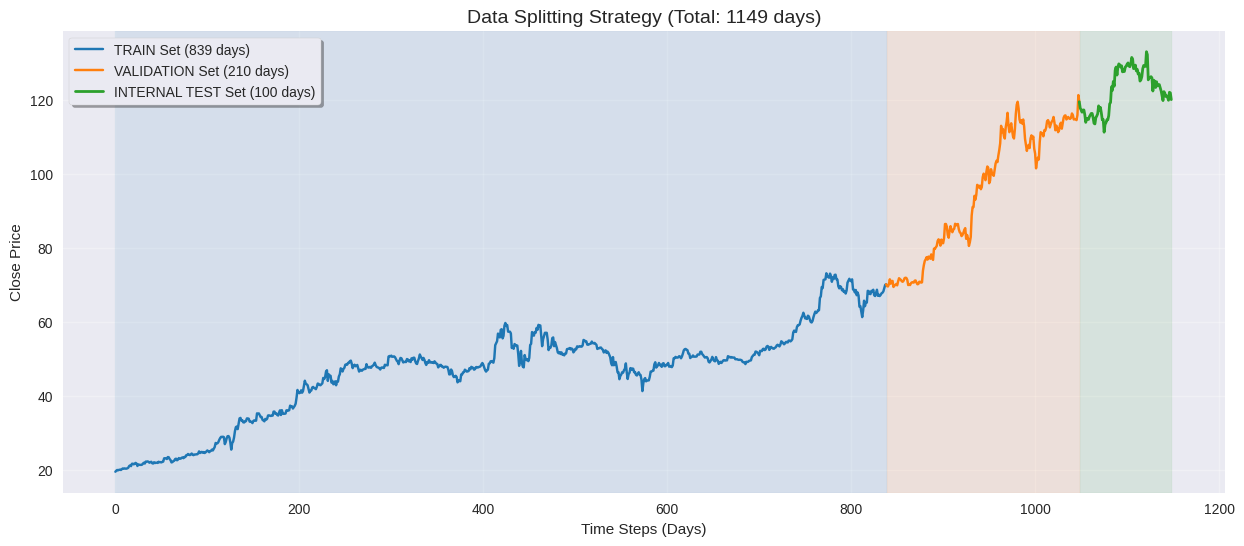

In [26]:
def plot_data_split():
    # 1. Lấy dữ liệu gốc
    df_plot = pd.read_csv('data/FPT_train.csv') # Đảm bảo đường dẫn đúng
    data = df_plot['close'].values
    total_len = len(data)
    
    # 2. Tính toán các điểm cắt (Theo logic của code tối ưu)
    TEST_LEN = 100
    
    # Phần dành cho phát triển model (Dev Set)
    dev_len = total_len - TEST_LEN
    
    # Trong Dev Set, chia 80% Train, 20% Val
    train_len = int(dev_len * 0.8)
    val_len = dev_len - train_len
    
    # 3. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    
    # Vẽ vùng Train
    plt.plot(range(0, train_len), data[0:train_len], 
             color='#1f77b4', label=f'TRAIN Set ({train_len} days)')
    
    # Vẽ vùng Validation (nối tiếp Train)
    plt.plot(range(train_len - 1, dev_len), data[train_len - 1:dev_len], 
             color='#ff7f0e', label=f'VALIDATION Set ({val_len} days)')
    
    # Vẽ vùng Test (nối tiếp Val)
    plt.plot(range(dev_len - 1, total_len), data[dev_len - 1:total_len], 
             color='#2ca02c', linewidth=2, label=f'INTERNAL TEST Set ({TEST_LEN} days)')
    
    # Tô màu nền để dễ phân biệt
    plt.axvspan(0, train_len, color='#1f77b4', alpha=0.1)
    plt.axvspan(train_len, dev_len, color='#ff7f0e', alpha=0.1)
    plt.axvspan(dev_len, total_len, color='#2ca02c', alpha=0.1)
    
    # Chú thích
    plt.title(f"Data Splitting Strategy (Total: {total_len} days)", fontsize=14)
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Close Price")
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    
    # In ra index cụ thể
    print(f"{'Set':<15} | {'Start Index':<12} | {'End Index':<12} | {'Length':<10}")
    print("-" * 55)
    print(f"{'TRAIN':<15} | {0:<12} | {train_len:<12} | {train_len}")
    print(f"{'VALIDATION':<15} | {train_len:<12} | {dev_len:<12} | {val_len}")
    print(f"{'INTERNAL TEST':<15} | {dev_len:<12} | {total_len:<12} | {TEST_LEN}")
    print("-" * 55)
    
    plt.show()

plot_data_split()

In [19]:
print("="*60)
print("STARTING GRID SEARCH")
print("="*60)
print(f"\nGrid Search Space:")
print(f"  - Variants: {VARIANTS}")
print(f"  - Models: {MODEL_TYPES}")
print(f"  - RevIN: {USE_REVIN_OPTIONS}")
print(f"  - Seq Lengths: {SEQ_LENS}")
print(f"  - HMM: {USE_HMM_OPTIONS}")
print("\n")

results = run_grid_search()

print("\n" + "="*60)
print("GRID SEARCH COMPLETED")
print("="*60)

STARTING GRID SEARCH

Grid Search Space:
  - Variants: ['Univariate', 'Multivariate']
  - Models: ['Linear', 'DLinear', 'NLinear']
  - RevIN: [True, False]
  - Seq Lengths: [7, 15, 30, 60, 120, 480]
  - HMM: [False, True]




Grid Search: 100%|██████████| 220/220 [56:21<00:00, 15.37s/it, Last=Mul_NLinear_480, MSE=2387]


GRID SEARCH COMPLETED


## 12. Results Analysis

In [20]:
# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('ValMSE')
results_df.to_csv('results/grid_search_results.csv', index=False)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

print(f"\nTotal experiments: {len(results_df)}")
print(f"\nTop 15 Best Models:")
display(results_df.head(15))

print(f"\nWorst 5 Models:")
display(results_df.tail(5))


RESULTS SUMMARY

Total experiments: 220

Top 15 Best Models:


,Variant,Model,RevIN,HMM,SeqLen,ValMSE,File
198,Multivariate,NLinear,NoRevIN,NoHMM,7,72.969307,Sub_Multivariate_NLinear_NoRevIN_NoHMM_Seq7_MS...
203,Multivariate,NLinear,NoRevIN,NoHMM,15,73.039597,Sub_Multivariate_NLinear_NoRevIN_NoHMM_Seq15_M...
88,Univariate,NLinear,NoRevIN,NoHMM,7,73.574539,Sub_Univariate_NLinear_NoRevIN_NoHMM_Seq7_MSE7...
213,Multivariate,NLinear,NoRevIN,NoHMM,60,74.049965,Sub_Multivariate_NLinear_NoRevIN_NoHMM_Seq60_M...
93,Univariate,NLinear,NoRevIN,NoHMM,15,74.384796,Sub_Univariate_NLinear_NoRevIN_NoHMM_Seq15_MSE...
125,Multivariate,Linear,RevIN,NoHMM,60,74.962250,Sub_Multivariate_Linear_RevIN_NoHMM_Seq60_MSE7...
89,Univariate,NLinear,NoRevIN,HMM3W30,7,76.025352,Sub_Univariate_NLinear_NoRevIN_HMM3W30_Seq7_MS...
169,Multivariate,DLinear,RevIN,NoHMM,60,76.342186,Sub_Multivariate_DLinear_RevIN_NoHMM_Seq60_MSE...
208,Multivariate,NLinear,NoRevIN,NoHMM,30,76.664856,Sub_Multivariate_NLinear_NoRevIN_NoHMM_Seq30_M...
201,Multivariate,NLinear,NoRevIN,HMM4W30,7,77.058952,Sub_Multivariate_NLinear_NoRevIN_HMM4W30_Seq7_...



Worst 5 Models:


,Variant,Model,RevIN,HMM,SeqLen,ValMSE,File
172,Multivariate,DLinear,RevIN,HMM4W30,60,3390.664795,Sub_Multivariate_DLinear_RevIN_HMM4W30_Seq60_M...
21,Univariate,Linear,RevIN,NoHMM,480,4888.312500,Sub_Univariate_Linear_RevIN_NoHMM_Seq480_MSE48...
65,Univariate,DLinear,RevIN,NoHMM,480,5073.298828,Sub_Univariate_DLinear_RevIN_NoHMM_Seq480_MSE5...
131,Multivariate,Linear,RevIN,NoHMM,480,5518.889160,Sub_Multivariate_Linear_RevIN_NoHMM_Seq480_MSE...
175,Multivariate,DLinear,RevIN,NoHMM,480,5628.676758,Sub_Multivariate_DLinear_RevIN_NoHMM_Seq480_MS...


In [21]:
# Detailed Analysis
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

# By Variant
print("\n📊 Average MSE by Variant:")
print(results_df.groupby('Variant')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))

# By Model Type
print("\n📊 Average MSE by Model Type:")
print(results_df.groupby('Model')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))

# By RevIN
print("\n📊 Average MSE by RevIN:")
print(results_df.groupby('RevIN')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))

# By Sequence Length
print("\n📊 Average MSE by Sequence Length:")
print(results_df.groupby('SeqLen')['ValMSE'].agg(['mean', 'std', 'min', 'max']).round(2))


DETAILED ANALYSIS

📊 Average MSE by Variant:
                mean     std    min      max
Variant                                     
Multivariate  516.72  883.57  72.97  5628.68
Univariate    233.27  679.31  73.57  5073.30

📊 Average MSE by Model Type:
           mean     std    min      max
Model                                  
DLinear  420.23  884.82  76.34  5628.68
Linear   415.15  844.49  74.96  5518.89
NLinear  204.21  432.67  72.97  2387.50

📊 Average MSE by RevIN:
           mean      std    min      max
RevIN                                   
NoRevIN  335.30   423.45  72.97  2387.50
RevIN    434.54  1153.72  74.96  5628.68

📊 Average MSE by Sequence Length:
           mean      std     min      max
SeqLen                                   
7        226.48   288.47   72.97  1252.37
15       199.06   227.59   73.04  1093.48
30       193.96   170.72   76.66   770.01
60       351.50   588.09   74.05  3390.66
120      233.95   171.10   87.74   463.48
480     3160.98  1898.13  

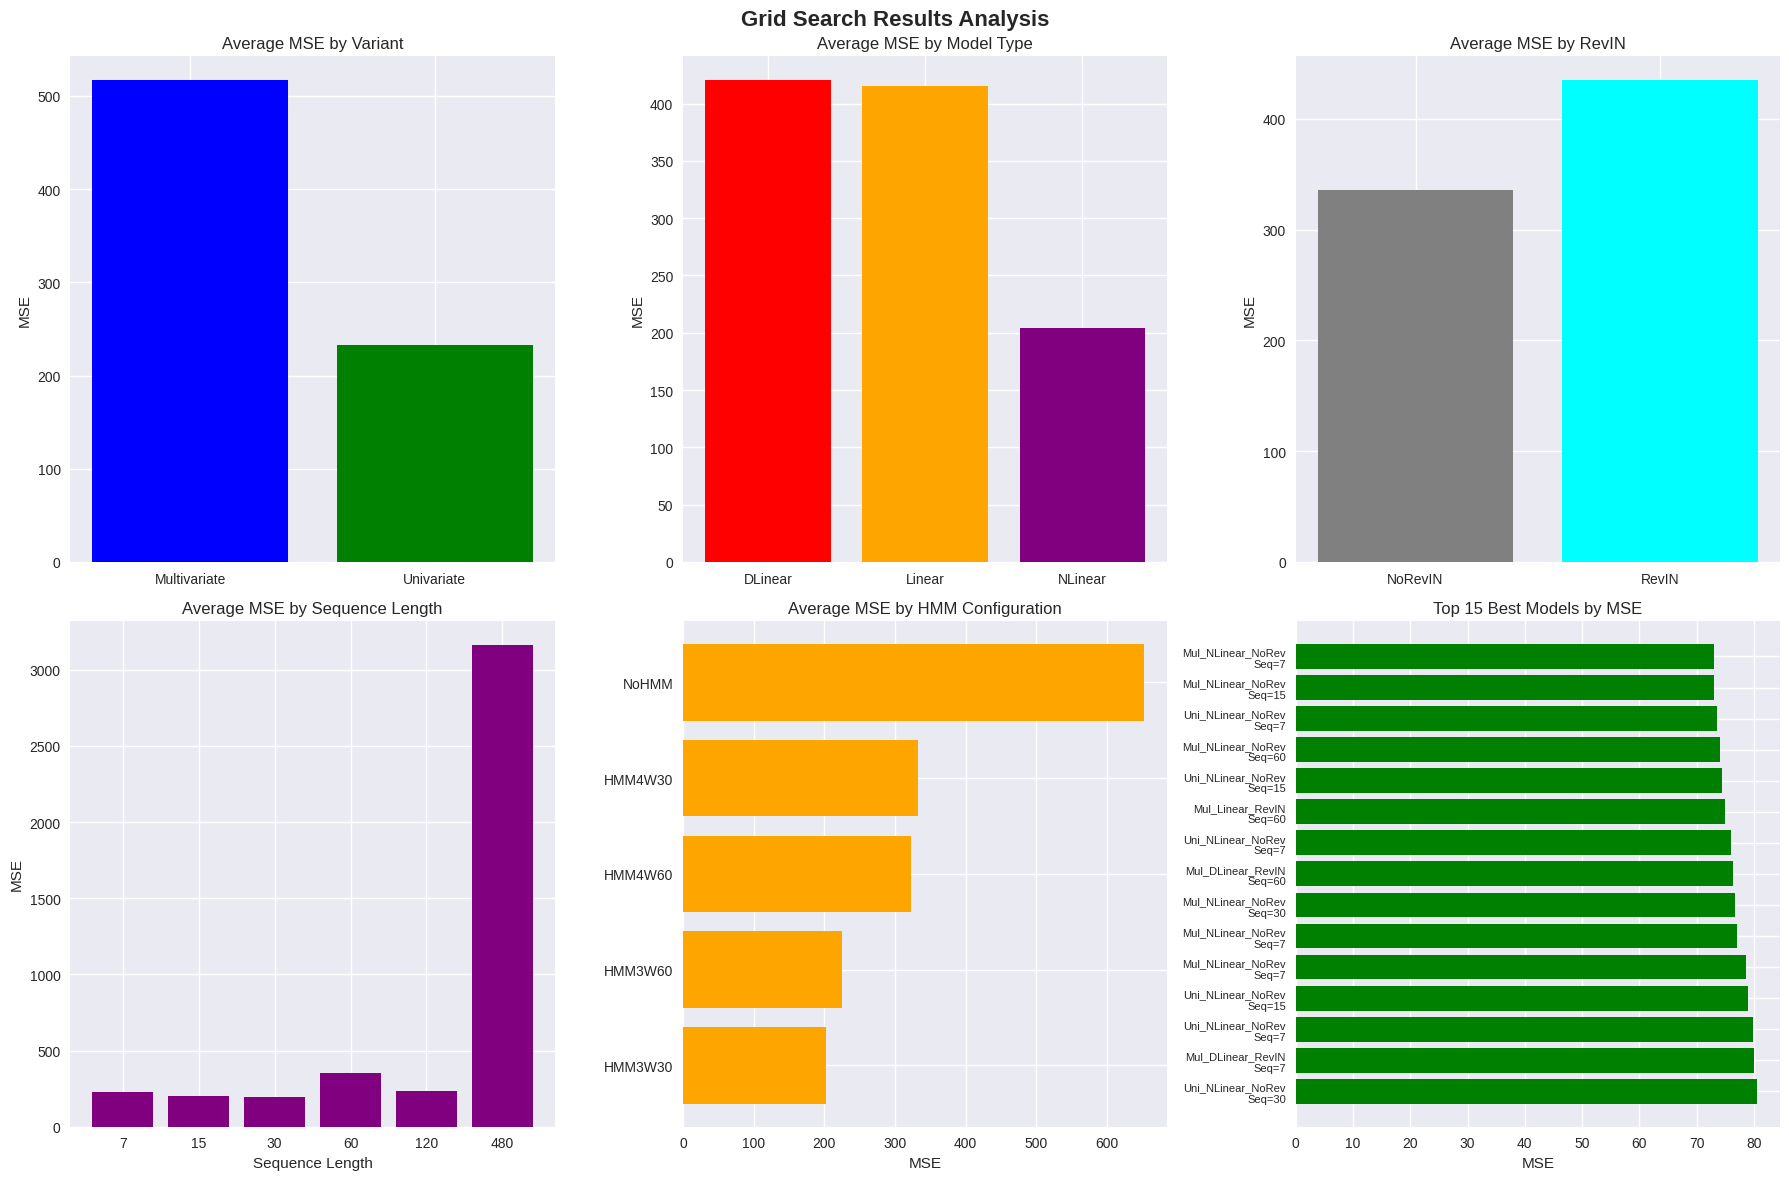

In [22]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Grid Search Results Analysis', fontsize=16, fontweight='bold')

# 1. MSE by Variant
variant_mse = results_df.groupby('Variant')['ValMSE'].mean()
axes[0, 0].bar(variant_mse.index, variant_mse.values, color=['blue', 'green'])
axes[0, 0].set_title('Average MSE by Variant', fontsize=12)
axes[0, 0].set_ylabel('MSE')

# 2. MSE by Model Type
model_mse = results_df.groupby('Model')['ValMSE'].mean()
axes[0, 1].bar(model_mse.index, model_mse.values, color=['red', 'orange', 'purple'])
axes[0, 1].set_title('Average MSE by Model Type', fontsize=12)
axes[0, 1].set_ylabel('MSE')

# 3. MSE by RevIN
revin_mse = results_df.groupby('RevIN')['ValMSE'].mean()
axes[0, 2].bar(revin_mse.index, revin_mse.values, color=['gray', 'cyan'])
axes[0, 2].set_title('Average MSE by RevIN', fontsize=12)
axes[0, 2].set_ylabel('MSE')

# 4. MSE by Sequence Length
seq_mse = results_df.groupby('SeqLen')['ValMSE'].mean()
axes[1, 0].bar(seq_mse.index.astype(str), seq_mse.values, color='purple')
axes[1, 0].set_title('Average MSE by Sequence Length', fontsize=12)
axes[1, 0].set_xlabel('Sequence Length')
axes[1, 0].set_ylabel('MSE')

# 5. MSE by HMM
hmm_mse = results_df.groupby('HMM')['ValMSE'].mean().sort_values()
axes[1, 1].barh(hmm_mse.index, hmm_mse.values, color='orange')
axes[1, 1].set_title('Average MSE by HMM Configuration', fontsize=12)
axes[1, 1].set_xlabel('MSE')

# 6. Top 15 Models
top15 = results_df.head(15)
labels = [f"{r['Variant'][:3]}_{r['Model']}_{r['RevIN'][:5]}\nSeq={r['SeqLen']}" for _, r in top15.iterrows()]
axes[1, 2].barh(range(len(top15)), top15['ValMSE'].values, color='green')
axes[1, 2].set_yticks(range(len(top15)))
axes[1, 2].set_yticklabels(labels, fontsize=8)
axes[1, 2].set_title('Top 15 Best Models by MSE', fontsize=12)
axes[1, 2].set_xlabel('MSE')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig('results/grid_search_analysis.png', dpi=150)
plt.show()

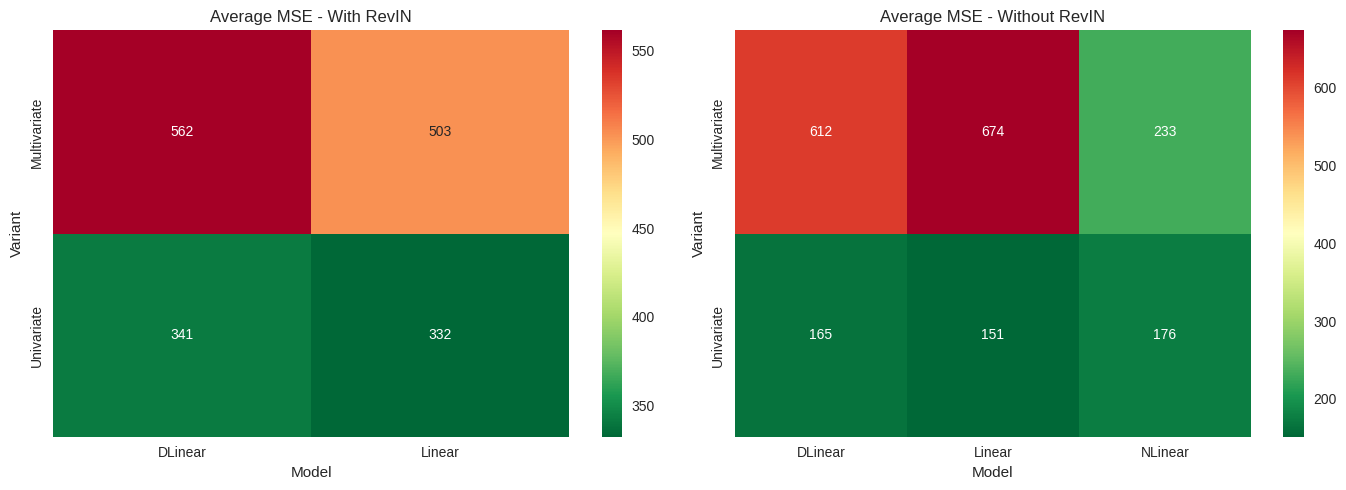

In [23]:
# Heatmap: Variant × Model × RevIN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pivot for RevIN
pivot_revin = results_df[results_df['RevIN'] == 'RevIN'].pivot_table(
    values='ValMSE', index='Variant', columns='Model', aggfunc='mean'
)
sns.heatmap(pivot_revin, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=axes[0])
axes[0].set_title('Average MSE - With RevIN', fontsize=12)

# Pivot for NoRevIN
pivot_norevin = results_df[results_df['RevIN'] == 'NoRevIN'].pivot_table(
    values='ValMSE', index='Variant', columns='Model', aggfunc='mean'
)
sns.heatmap(pivot_norevin, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=axes[1])
axes[1].set_title('Average MSE - Without RevIN', fontsize=12)

plt.tight_layout()
plt.savefig('results/heatmap_analysis.png', dpi=150)
plt.show()

## 13. Summary và Kết luận

In [24]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset: FPT Stock ({len(df)} days)")
print(f"📅 Date Range: {df['time'].min().date()} to {df['time'].max().date()}")

print(f"\n🔬 Total Experiments: {len(results_df)}")

print(f"\n🏆 TOP 5 BEST MODELS:")
for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['Variant']}_{row['Model']}_{row['RevIN']} | Seq={row['SeqLen']} | {row['HMM']} | MSE={row['ValMSE']:.2f}")

print(f"\n📈 KEY FINDINGS:")
best_variant = results_df.groupby('Variant')['ValMSE'].mean().idxmin()
best_model = results_df.groupby('Model')['ValMSE'].mean().idxmin()
best_revin = results_df.groupby('RevIN')['ValMSE'].mean().idxmin()
best_seq = results_df.groupby('SeqLen')['ValMSE'].mean().idxmin()

print(f"   - Best Variant: {best_variant}")
print(f"   - Best Model Type: {best_model}")
print(f"   - Best Normalization: {best_revin}")
print(f"   - Best Sequence Length: {best_seq}")

print(f"\n📁 OUTPUT FILES:")
print(f"   - Results CSV: results/grid_search_results.csv")
print(f"   - Analysis Plot: results/grid_search_analysis.png")
print(f"   - Heatmap: results/heatmap_analysis.png")
print(f"   - Submissions: {SUBMISSION_DIR}/ ({len(results_df)} files)")

print("\n" + "="*60)
print("DONE! 🎉")
print("="*60)

FINAL SUMMARY

📊 Dataset: FPT Stock (1149 days)
📅 Date Range: 2020-08-03 to 2025-03-10

🔬 Total Experiments: 220

🏆 TOP 5 BEST MODELS:
   1. Multivariate_NLinear_NoRevIN | Seq=7 | NoHMM | MSE=72.97
   2. Multivariate_NLinear_NoRevIN | Seq=15 | NoHMM | MSE=73.04
   3. Univariate_NLinear_NoRevIN | Seq=7 | NoHMM | MSE=73.57
   4. Multivariate_NLinear_NoRevIN | Seq=60 | NoHMM | MSE=74.05
   5. Univariate_NLinear_NoRevIN | Seq=15 | NoHMM | MSE=74.38

📈 KEY FINDINGS:
   - Best Variant: Univariate
   - Best Model Type: NLinear
   - Best Normalization: NoRevIN
   - Best Sequence Length: 30

📁 OUTPUT FILES:
   - Results CSV: results/grid_search_results.csv
   - Analysis Plot: results/grid_search_analysis.png
   - Heatmap: results/heatmap_analysis.png
   - Submissions: submissions/without_Loss_tuning/ (220 files)

DONE! 🎉


In [25]:
# List all submission files
print("\n📂 All Submission Files:")
print("-" * 80)
for i, filename in enumerate(sorted(results_df['File'].tolist()), 1):
    print(f"{i:3d}. {filename}")


📂 All Submission Files:
--------------------------------------------------------------------------------
  1. Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq15_MSE536.csv
  2. Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq30_MSE503.csv
  3. Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq60_MSE696.csv
  4. Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq7_MSE571.csv
  5. Sub_Multivariate_DLinear_NoRevIN_HMM3W60_Seq15_MSE487.csv
  6. Sub_Multivariate_DLinear_NoRevIN_HMM3W60_Seq30_MSE504.csv
  7. Sub_Multivariate_DLinear_NoRevIN_HMM3W60_Seq60_MSE538.csv
  8. Sub_Multivariate_DLinear_NoRevIN_HMM3W60_Seq7_MSE816.csv
  9. Sub_Multivariate_DLinear_NoRevIN_HMM4W30_Seq15_MSE355.csv
 10. Sub_Multivariate_DLinear_NoRevIN_HMM4W30_Seq30_MSE371.csv
 11. Sub_Multivariate_DLinear_NoRevIN_HMM4W30_Seq60_MSE466.csv
 12. Sub_Multivariate_DLinear_NoRevIN_HMM4W30_Seq7_MSE429.csv
 13. Sub_Multivariate_DLinear_NoRevIN_HMM4W60_Seq15_MSE1083.csv
 14. Sub_Multivariate_DLinear_NoRevIN_HMM4W60_Seq30_MSE657.csv
 15. Sub_Multi